In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


In [3]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427

#function is used to convert all names to ASCII Characters, refer to example below where we convert 'Ślusàrski' to 'Slusarski'.
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [4]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
 #each line contatins a name
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

#now read each file and write each country to a dictionary, and add each name to its value

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(n_categories)
print(all_categories)

18
['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


In [5]:
#convert a letter to its respective index to refer to for one hot encoding

def letterToIndex(letter):
    return all_letters.find(letter)

In [6]:
#convert each letter to one hot encoded tensor

def letterToTensor(letter):
    tensor = torch.zeros(1,n_letters)
    tensor[0,letterToIndex(letter)] = 1
    return tensor

In [7]:
#conver each name to tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line),1,n_letters)
    for ind,letter in enumerate(line):     #enumerate returns the count and the object
        tensor[ind,0,letterToIndex(letter)] = 1
    return tensor

In [8]:
lineToTensor('Gurkirat').size() #one letter has 1,57 tensors

torch.Size([8, 1, 57])

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
device

device(type='cpu')

In [11]:
a = torch.randint(2,(1,))
if a.item==1:
    print('yes')

In [12]:
# revised RNN architecture
class SNN1(nn.Module):

    def __init__(self,input_size,hidden_size,output_size):
        super().__init__()
        self.combined_list = []
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size+hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size+hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.gain = torch.tensor(1,requires_grad=True,dtype=torch.float32)
        self.bias = torch.tensor(0,requires_grad=True,dtype=torch.float32)


    def forward(self,input,hidden,combinedList):
        combined = torch.cat((input,hidden),1)
        hidden = self.i2h(combined)
        if len(combinedList)!=0:
            for i in range(1,len(combinedList)):
                hidden += combinedList[i]
        hidden = hidden - torch.mean(hidden,1)
        hidden = hidden / torch.std(hidden,1)
        hidden = self.gain*hidden + self.bias
        combinedList.append(hidden)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output,hidden
        
    def initHidden(self):
        return torch.zeros(1,self.hidden_size)

    def initCombined(self):
        return []     
            
            

In [13]:
#intialised model
n_hidden = 128
rnn = SNN1(n_letters,n_hidden,n_categories)

In [14]:
#function to print the predicted category
def categoryFromOutput(output):
    max, ind = output.topk(1)
    ind = ind[0].item()
    return all_categories[ind], ind

In [15]:
#function to choose random sample for training loop

def randomChoice(l):
    return l[random.randint(0,len(l)-1)]

def randomTrainingSample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype = torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [16]:

for name, param in rnn.named_parameters():
    print(name)

i2h.weight
i2h.bias
i2o.weight
i2o.bias


In [17]:
#define the model parameters to be updated for backpropagation

rnn.gain.retain_grad()
rnn.bias.retain_grad()
parameters = [rnn.i2h.weight,rnn.i2h.bias,rnn.i2o.weight,rnn.i2o.bias,rnn.gain,rnn.bias]

In [18]:
#training loop
loss_fn = nn.NLLLoss()
optim = torch.optim.SGD(parameters,lr=0.005)

def Train(category_tensor,line_tensor):
    hidden = rnn.initHidden()
    combined = rnn.initCombined()
    y = category_tensor
    x = line_tensor
    for i in range(x.size()[0]):
        output,hidden = rnn(x[i],hidden,combined)
    
    loss = loss_fn(output,y)

    optim.zero_grad()
    loss.backward(retain_graph=True)
    optim.step()

    return output, loss.item()


In [20]:
#trianing
current_loss = 0
All_losses = []
plot_steps, print_steps = 1000,5000
epochs = 100000

for i in range(epochs):
    category,line,category_tensor,line_tensor = randomTrainingSample()

    output, loss = Train(category_tensor,line_tensor)
    current_loss += loss
    if (i+1)%plot_steps==0:
        All_losses.append(current_loss/plot_steps)
        if (i+1)%print_steps==0:
            print(f'Step {i+1} --> {All_losses[-1]} ')
        current_loss=0


Step 5000 --> 1.9481572367101907 
Step 10000 --> 1.8493522914126515 
Step 15000 --> 1.7744438360705972 
Step 20000 --> 1.6798364085294306 
Step 25000 --> 1.597073744993657 
Step 30000 --> 1.6700454272739589 
Step 35000 --> 1.5419771023048088 
Step 40000 --> 1.553313085269183 
Step 45000 --> 1.4681473099170252 
Step 50000 --> 1.3991814551290591 
Step 55000 --> 1.487695987897925 
Step 60000 --> 1.4435733576272614 
Step 65000 --> 1.409589378452394 
Step 70000 --> 1.3576586224441416 
Step 75000 --> 1.33094278729707 
Step 80000 --> 1.3695006030160002 
Step 85000 --> 1.292694068588782 
Step 90000 --> 1.3059685379709116 
Step 95000 --> 1.3033529622834177 
Step 100000 --> 1.29579237804655 


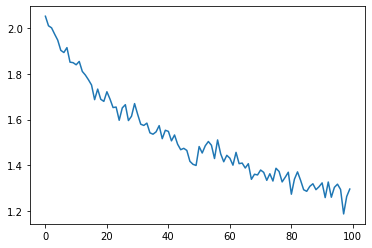

In [21]:
#ploting the loss function
plt.plot(All_losses)

In [22]:
# RNN architecture
class RNN(nn.Module):
    def __init__(self, Input_size, Hidden_size, Output_size):
        super(RNN, self).__init__()

        self.Hidden_size = Hidden_size

        self.i2h = nn.Linear(Input_size + Hidden_size, Hidden_size)
        self.h2o = nn.Linear(Hidden_size, Output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, Hidden):
        Combined = torch.cat((input, Hidden), 1)
        Hidden = self.i2h(Combined)
        Output = self.h2o(Hidden)
        Output = self.softmax(Output)
        return Output, Hidden

    def initHidden(self):
        return torch.zeros(1, self.Hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [23]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)



In [24]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9568, -2.9334, -2.9691, -2.8457, -2.8518, -2.9026, -2.7945, -2.8785,
         -2.8013, -2.8419, -2.8251, -2.8790, -2.9700, -2.8820, -2.9386, -2.8777,
         -2.9442, -2.9631]], grad_fn=<LogSoftmaxBackward0>)


In [25]:
def CategoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(CategoryFromOutput(output))

('German', 6)


In [26]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Korean / line = Kwak
category = Polish / line = Grzeskiewicz
category = Irish / line = Cathain
category = Vietnamese / line = Chu
category = French / line = Guerin
category = Irish / line = Connell
category = English / line = Alanson
category = Russian / line = Jaganov
category = Polish / line = Warszawski
category = Arabic / line = Shamoun


In [27]:
criterion = nn.NLLLoss()

In [28]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    Hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        Output, Hidden = rnn(line_tensor[i], Hidden)

    loss = criterion(output, category_tensor)
    loss.backward(retain_graph = True)

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [29]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 16s) 2.8790 Rim / German ✗ (Korean)
10000 10% (0m 31s) 2.8013 Seaghdha / German ✗ (Irish)
15000 15% (0m 47s) 2.8518 Kurray / German ✗ (English)
20000 20% (1m 2s) 2.9568 Amari / German ✗ (Arabic)
25000 25% (1m 16s) 2.9568 Baba / German ✗ (Arabic)
30000 30% (1m 32s) 2.8457 Rijnders / German ✗ (Dutch)
35000 35% (1m 47s) 2.8518 Ebden / German ✗ (English)
40000 40% (2m 2s) 2.8820 Cardozo / German ✗ (Portuguese)
45000 45% (2m 18s) 2.8777 Sutherland / German ✗ (Scottish)
50000 50% (2m 32s) 2.9631 Luong / German ✗ (Vietnamese)
55000 55% (2m 48s) 2.8419 Paternoster / German ✗ (Italian)
60000 60% (3m 3s) 2.9568 Mikhail / German ✗ (Arabic)
65000 65% (3m 18s) 2.9334 Rang / German ✗ (Chinese)
70000 70% (3m 33s) 2.9334 Huan / German ✗ (Chinese)
75000 75% (3m 48s) 2.9334 Ruan / German ✗ (Chinese)
80000 80% (4m 3s) 2.8419 Airo / German ✗ (Italian)
85000 85% (4m 19s) 2.8419 Palumbo / German ✗ (Italian)
90000 90% (4m 34s) 2.7945 Schlender / German ✓
95000 95% (4m 49s) 2.8251 Kikui / German ✗

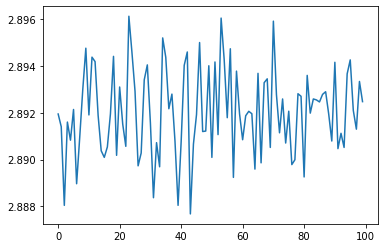

In [30]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [35]:
#code to evaluate for user input
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

In [36]:
#predict human input

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Ronaldo')
predict('Sainz')
predict('Hamilton')


> Ronaldo
(-0.23) Czech
(-1.59) Polish
(-8.31) Vietnamese

> Sainz
(-0.22) Czech
(-1.63) Polish
(-8.26) Vietnamese

> Hamilton
(-0.22) Czech
(-1.64) Polish
(-8.27) Vietnamese


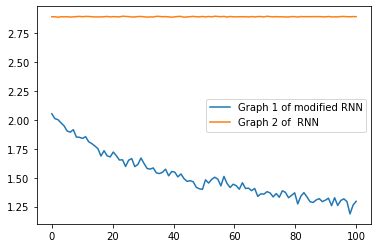

In [45]:
# loss function graph
import numpy as np
import matplotlib.pyplot as plt

# Example data for two graphs
x = np.linspace(0, 100, 100)
y1 = All_losses
y2 = all_losses

# Plot the two graphs
plt.plot(x, y1, label='Graph 1 of modified RNN')
plt.plot(x, y2, label='Graph 2 of  RNN')
plt.legend()
plt.show()



In [ ]:
# Calculate mean squared error (MSE)
mse = np.mean((y1 - y2) ** 2)
print("Mean Squared Error (MSE):", mse)